<a href="https://colab.research.google.com/github/ameyas1/Blackpink_Face_Recognition/blob/master/blackpink_non_max_supression_ssd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('drive/My Drive/tensorflow-face-detection-master.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
import os
import time
import numpy as np
import tensorflow as tf

# BASE_DIR = os.path.dirname(__file__) + '/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'tensorflow-face-detection-master/model/frozen_inference_graph_face.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'tensorflow-face-detection-master/protos/face_label_map.pbtxt'


class FaceDetector:
    def __init__(self):
        # Load models
        self.detection_graph = tf.Graph()
        self.sess = tf.Session(graph=self.detection_graph)
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile( PATH_TO_CKPT, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        self.boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        self.scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')

    def __del__(self):
        self.sess.close()

    def detect(self, image):
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_expanded = np.expand_dims(image, axis=0)

        # Actual detection.
        start_time = time.time()
        (boxes, scores, classes, num_detections) = self.sess.run(
            [self.boxes, self.scores, self.classes, self.num_detections],
            feed_dict={self.image_tensor: image_expanded})
        elapsed_time = time.time() - start_time
        print('inference time cost: {}'.format(elapsed_time))

        # Ratio to real position
        boxes[0, :, [0, 2]] = (boxes[0, :, [0, 2]]*image.shape[0])
        boxes[0, :, [1, 3]] = (boxes[0, :, [1, 3]]*image.shape[1])
        return np.squeeze(boxes).astype(int), np.squeeze(scores)

In [4]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import numpy as np
import cv2
import time
import numpy as np
from tensorflow.keras.models import load_model
# from detection.FaceDetector import FaceDetector
# from recognition.FaceRecognition import FaceRecognition
# from classifier.FaceClassifier import FaceClassifier

face_detector = FaceDetector()

fc_model=load_model('drive/My Drive/cp/weights-186-0.94.hdf5')


W0626 07:08:01.782593 140030393997184 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0626 07:08:01.784256 140030393997184 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0626 07:08:01.787229 140030393997184 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

In [0]:
id_dict={0:'Jennie',1:'Jisoo',2:'Lisa',3:'Rose'}

In [0]:
img_array = []

In [0]:
# import the necessary packages
import numpy as np
 
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
 
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
 
	# initialize the list of picked indexes	
	pick = []
 
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
 
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
 
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
 
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
 
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [8]:
video_capture = cv2.VideoCapture('blackpink_video_input.mp4')

print('Start Recognition!')







prevTime = 0
while(video_capture.isOpened()):
    ret, frame = video_capture.read()
    if ret == False:
        break
#     frame = cv2.resize(frame, (0, 0), fx=0.4, fy=0.4)  # resize frame (optional)

    curTime = time.time()  # calc fps
    find_results = []

    frame = frame[:, :, 0:3]
    boxes, scores = face_detector.detect(frame)
    face_boxes = non_max_suppression_fast(boxes[np.argwhere(scores>0.3).reshape(-1)],0.5)
    
    
#     face_scores = scores[np.argwhere(scores>0.3).reshape(-1)]
    print('Detected_FaceNum: %d' % len(face_boxes))

    if len(face_boxes) > 0:
        for i in range(len(face_boxes)):
            box = face_boxes[i]
            cropped_face = frame[box[0]:box[2], box[1]:box[3], :]
            cropped_face = cv2.resize(cropped_face, (224, 224), interpolation=cv2.INTER_AREA)
            
            x=img_to_array(cropped_face)
            x = preprocess_input(x)
            x=np.expand_dims(x, axis=0)
            classes = fc_model.predict(x)[0]
            id=np.argmax(classes)
            for j in id_dict:
                if j==id:
                    name=id_dict[id]
            
#             feature = face_recognition.recognize(cropped_face)
#             name = face_classfier.classify(feature)


            cv2.rectangle(frame, (box[1], box[0]), (box[3], box[2]), (0, 255, 0), 2)

            # plot result idx under box
            text_x = box[1]
            text_y = box[2] + 20
            cv2.putText(frame, name, (text_x, text_y), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        1, (0, 0, 255), thickness=1, lineType=2)
    else:
        print('Unable to align')

    sec = curTime - prevTime
    prevTime = curTime
    fps = 1 / (sec)
    str = 'FPS: %2.3f' % fps
    text_fps_x = len(frame[0]) - 150
    text_fps_y = 20
    cv2.putText(frame, str, (text_fps_x, text_fps_y),
                cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 0), thickness=1, lineType=2)

#     cv2_imshow(frame)
    height, width, layers = frame.shape
    size = (width,height)
    img_array.append(frame)
    
    



video_capture.release()
cv2.destroyAllWindows()

out = cv2.VideoWriter('blackpink_video_output.avi',cv2.VideoWriter_fourcc(*'DIVX'), 23, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

Start Recognition!
inference time cost: 3.3373100757598877
Detected_FaceNum: 0
Unable to align
inference time cost: 0.02704000473022461
Detected_FaceNum: 0
Unable to align
inference time cost: 0.026724576950073242
Detected_FaceNum: 0
Unable to align
inference time cost: 0.026958703994750977
Detected_FaceNum: 0
Unable to align
inference time cost: 0.029929399490356445
Detected_FaceNum: 1
inference time cost: 0.026108264923095703
Detected_FaceNum: 1
inference time cost: 0.023788928985595703
Detected_FaceNum: 1
inference time cost: 0.0256805419921875
Detected_FaceNum: 1
inference time cost: 0.023631811141967773
Detected_FaceNum: 1
inference time cost: 0.02389693260192871
Detected_FaceNum: 1
inference time cost: 0.028046369552612305
Detected_FaceNum: 1
inference time cost: 0.023368120193481445
Detected_FaceNum: 1
inference time cost: 0.025110960006713867
Detected_FaceNum: 1
inference time cost: 0.025146961212158203
Detected_FaceNum: 1
inference time cost: 0.026015758514404297
Detected_Face

Start Recognition!
inference time cost: 2.7019405364990234
Detected_FaceNum: 1


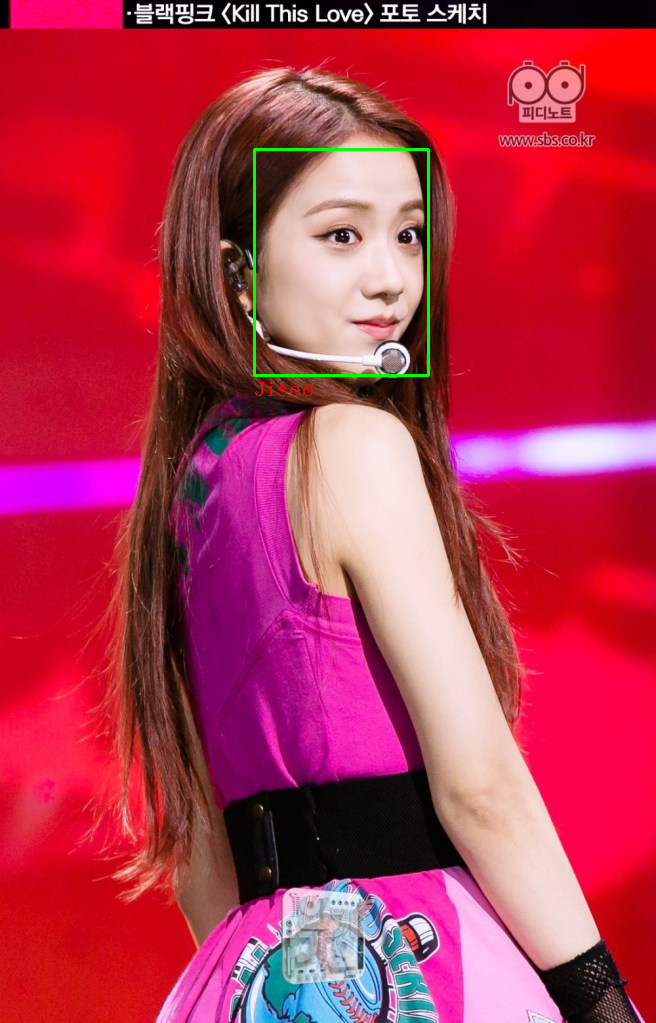

<Figure size 1080x1080 with 0 Axes>

In [0]:
import cv2
import time
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

%matplotlib inline

face_detector = FaceDetector()

img = cv2.imread('1-BLACKPINK-SBS-Inkigayo-PD-Note-14-April-2019-Performance.jpg')
print('Start Recognition!')

boxes, scores = face_detector.detect(img)
face_boxes = boxes[np.argwhere(scores>0.3).reshape(-1)]
face_scores = scores[np.argwhere(scores>0.3).reshape(-1)]
print('Detected_FaceNum: %d' % len(face_boxes))

plt.figure(figsize=(15,15))

if len(face_boxes) > 0:
  for i in range(len(face_boxes)):
    box = face_boxes[i]
    cropped_face = img[box[0]:box[2], box[1]:box[3], :]
    cropped_face = cv2.resize(cropped_face, (224, 224), interpolation=cv2.INTER_AREA)
            
    x=img_to_array(cropped_face)
    x = preprocess_input(x)
    x=np.expand_dims(x, axis=0)
    classes = fc_model.predict(x)[0]
    id=np.argmax(classes)
    for j in id_dict:
      if j==id:
        name=id_dict[id]
    cv2.rectangle(img, (box[1], box[0]), (box[3], box[2]), (0, 255, 0), 2)

            # plot result idx under box
    text_x = box[1]
    text_y = box[2] + 20
    cv2.putText(img, name, (text_x, text_y), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        1, (0, 0, 255), thickness=1, lineType=2)
else:
  print('Unable to align')
  
  
cv2_imshow(img)